## Q1: Conduct a cross selling analysis for the grocery transaction dataset.

### Exploratory Data Analysis (EDA)

In [96]:
# read Q1.txt as df
import pandas as pd
Q1_df = pd.read_csv('Q1.txt', sep='\t', header=None)
Q1_df.head()
Q1_df.shape

(9835, 1)

Size: The data contains 9835 lines in total.
Data types: This is a text data, each line represents a transaction record.

In [97]:
Q1_df.head()

,0
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese ,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."


As all sales items are in a single column, in order to conduct the cross selling analysis, we need to split the items in each transaction into separate columns via one-hot encoding.

### Data Preprocessing

In [98]:
# each line represent a unique sales ID; rename the original column as 'sales_detail', add a new column 'sales_ID' from the original index
Q1_df.columns = ['sales_detail']
Q1_df['sales_ID'] = Q1_df.index
# rearrange the columns
Q1_df = Q1_df[['sales_ID', 'sales_detail']]
Q1_df.head()

,sales_ID,sales_detail
0,0,"citrus fruit,semi-finished bread,margarine,rea..."
1,1,"tropical fruit,yogurt,coffee"
2,2,whole milk
3,3,"pip fruit,yogurt,cream cheese ,meat spreads"
4,4,"other vegetables,whole milk,condensed milk,lon..."


In [99]:
# One-hot encoding for the sales_detail column
Q1_df = Q1_df.join(Q1_df['sales_detail'].str.get_dummies(sep=','))

In [100]:
# check if the one-hot encoding is correct, for example, if the sales_detail contain 'citrus fruit', the 'citrus fruit' column should be 1, show 'sales detail' and 'citrus fruit' columns
Q1_df[['citrus fruit']].loc[Q1_df['sales_detail'].str.contains('citrus fruit')].value_counts()

citrus fruit
1               814
Name: count, dtype: int64

In [101]:
# drop the original 'sales_detail' column
Q1_df = Q1_df.drop(columns=['sales_detail'])
Q1_df.head()

,sales_ID,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [102]:
# generate total number of columns except 'sales_ID'
Q1_df.shape[1] - 1

169

Variables: The data contains only one type of variable at first, but after one-hot encoding, it contain total of 169 variables.

### Distribution of Items

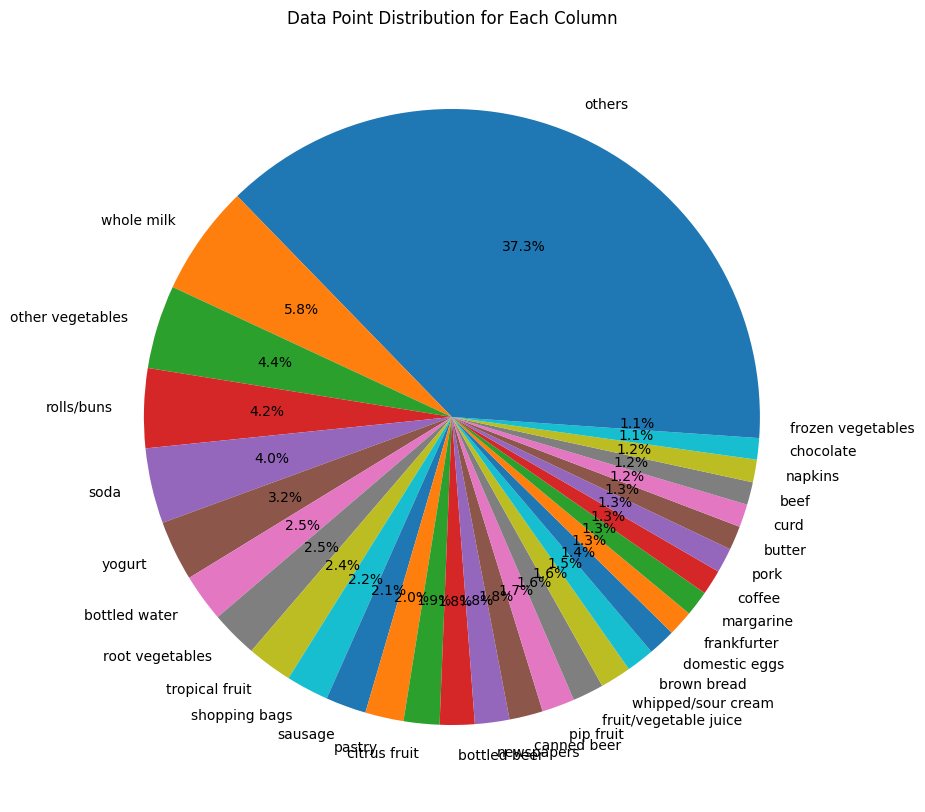

1.0000000000000002

In [103]:
# data point distribution for each column into a pie chart
import matplotlib.pyplot as plt
import seaborn as sns

# calculate the data point distribution for each column
data_point_distribution = Q1_df.iloc[:, 1:].sum()
# convert columns into percentage
data_point_distribution = data_point_distribution / data_point_distribution.sum()

# groupping the data point distribution into 'others' if the percentage is less than 1%, then remove the original columns
data_point_distribution = data_point_distribution[data_point_distribution >= 0.01]
data_point_distribution['others'] = 1 - data_point_distribution.sum()

# plot the pie chart into accending order
data_point_distribution = data_point_distribution.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
plt.pie(data_point_distribution, labels=data_point_distribution.index, autopct='%1.1f%%')
plt.title('Data Point Distribution for Each Column')
plt.show()
# sum should be 1
data_point_distribution.sum()

As per the distribution of the data, the top 10 items are as follows:

In [104]:
data_point_distribution.iloc[1:11]

whole milk          0.057947
other vegetables    0.043881
rolls/buns          0.041714
soda                0.039546
yogurt              0.031637
bottled water       0.025065
root vegetables     0.024719
tropical fruit      0.023797
shopping bags       0.022344
sausage             0.021307
dtype: float64

### Distribution Pattern of number of items purchased per transaction

<Figure size 1000x1000 with 0 Axes>

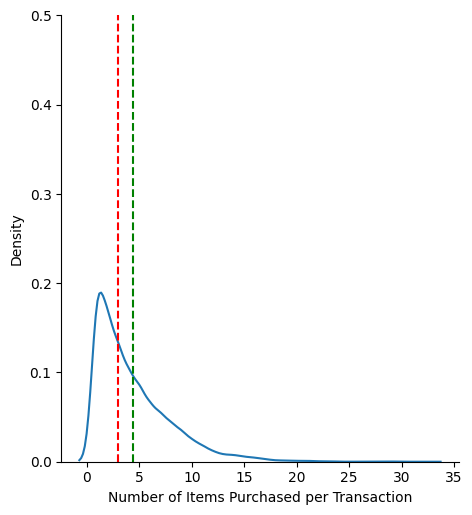

In [105]:
# find the distribution curve of the number of items purchased per transaction to see if it is a normal distribution, with mean purchase number is the highers
# find the number of items purchased per transaction by summing by row first
trans_ID_distribution = Q1_df.iloc[:, 1:].sum(axis=1)
# form a distribution curve
plt.figure(figsize=(10, 10))
sns.displot(trans_ID_distribution, kind='kde')
# mark x-axis and y-axis
plt.xlabel('Number of Items Purchased per Transaction')
plt.ylabel('Density')
# show median and mean line
plt.axvline(x=trans_ID_distribution.median(), color='r', linestyle='--', label='Median')
plt.axvline(x = trans_ID_distribution.mean(), color = 'g', linestyle = '--', label = 'Mean')
# expand the scope of y-axis
plt.ylim(0, 0.5)
plt.show()

As per the distribution of number of items purchased per transaction, this is a left-skewed distribution, with the majority of transactions containing 1-2 items.

### Use Associate rule mining to find the cross selling items

In [117]:
# use associate rule mining to find the most common item pairs
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# As the distribution of itemsets are very sparse (the most frequent itemset is only about 5%), we can set the minimum support to 0.05
# find the frequent item sets with a minimum support of 0.05.
frequent_itemsets = apriori(Q1_df.iloc[:, 1:], min_support=0.05, use_colnames=True)
frequent_itemsets

C:\Users\kwokt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.052466,(beef)
1,0.080529,(bottled beer)
2,0.110524,(bottled water)
3,0.064870,(brown bread)
4,0.055414,(butter)
5,0.077682,(canned beer)
6,0.082766,(citrus fruit)
7,0.058058,(coffee)
8,0.053279,(curd)
9,0.063447,(domestic eggs)


As per the association rule mining, the top 6 cross selling items are as follows:

In [131]:
# find the most common item pairs
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)
rules.sort_values(by='confidence', ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(yogurt),(whole milk),0.139502,0.255516,0.056024,0.401603,1.571735,0.020379,1.244132,0.422732
1,(other vegetables),(whole milk),0.193493,0.255516,0.074835,0.386758,1.513634,0.025394,1.214013,0.420750
2,(rolls/buns),(whole milk),0.183935,0.255516,0.056634,0.307905,1.205032,0.009636,1.075696,0.208496
3,(whole milk),(other vegetables),0.255516,0.193493,0.074835,0.292877,1.513634,0.025394,1.140548,0.455803
4,(whole milk),(rolls/buns),0.255516,0.183935,0.056634,0.221647,1.205032,0.009636,1.048452,0.228543
5,(whole milk),(yogurt),0.255516,0.139502,0.056024,0.219260,1.571735,0.020379,1.102157,0.488608


### Suggested Strategy for cross selling items based on the analysis:

In [138]:
# add antecedents and consequents as combination of bundles
bundles = rules.copy()
bundles['antecedents'] = bundles['antecedents'].apply(lambda x: ', '.join(list(x)))
bundles['consequents'] = bundles['consequents'].apply(lambda x: ', '.join(list(x)))
# remove rows if combination of antecedents and consequents are the same via set properties
bundles['bundle'] = list(zip(bundles['antecedents'], bundles['consequents']))
bundles['bundle'] = bundles['bundle'].apply(lambda x: ', '.join(sorted(list(set(x)))))
bundles = bundles.drop_duplicates(subset='bundle')
bundles.sort_values(by='confidence', ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,bundle
0,whole milk,other vegetables,0.255516,0.193493,0.074835,0.292877,1.513634,0.025394,1.140548,0.455803,"other vegetables, whole milk"
1,whole milk,rolls/buns,0.255516,0.183935,0.056634,0.221647,1.205032,0.009636,1.048452,0.228543,"rolls/buns, whole milk"
2,whole milk,yogurt,0.255516,0.139502,0.056024,0.219260,1.571735,0.020379,1.102157,0.488608,"whole milk, yogurt"


As per the analysis, combinations of the following items can be suggested for cross selling:
* {whole milk, other vegetables}
* {whole milk, rolls/buns}
* {whole milk, soda}